In [53]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

In [54]:
# Reading the dataset
data_csv = "dataset.csv"
df = pd.read_csv(data_csv)
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (1089, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-31,1196.400024,1212.400024,1182.000000,1201.900024,1201.900024,124.0
1,2014-01-02,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0
2,2014-01-03,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0
3,2014-01-06,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0
4,2014-01-07,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0


In [55]:
# Verifying null values and deleting name from dataset
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()
# Drop Date column
# df.pop("Date")

print('Dataset shape: ', df.shape)

     Open  High  Low  Close  Adj Close  Volume
127   NaN   NaN  NaN    NaN        NaN     NaN
230   NaN   NaN  NaN    NaN        NaN     NaN
248   NaN   NaN  NaN    NaN        NaN     NaN
515   NaN   NaN  NaN    NaN        NaN     NaN
535   NaN   NaN  NaN    NaN        NaN     NaN
Dataset shape:  (1081, 7)


In [56]:
print("Minimum: {}\nMaximum: {}\nMean: {}\nMedian: {}\nSD: {}\nSkewness: {}\nKurtosis: {}".format(df["Low"].min(), df["High"].max(), 
df["Open"].mean(), df["Open"].median(), df["Open"].std(), df["Open"].skew(), df["Open"].kurtosis()))

Minimum: 1046.199951
Maximum: 1391.400024
Mean: 1239.990934614246
Median: 1251.0
SD: 72.09937994027128
Skewness: -0.5455305158449637
Kurtosis: -0.3520037164214358


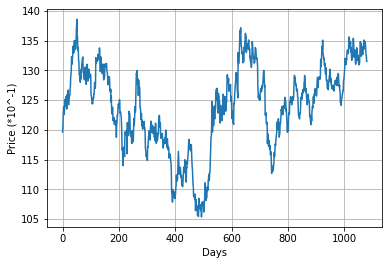

In [57]:
lastday_2017 = df.loc[df["Date"]=="2017-12-29"].index.values[0]
df = df["Open"].values


plt.figure()
plt.plot(df/10)
plt.xlabel("Days")
plt.ylabel("Price (*10^-1)")
plt.grid()
plt.show()

In [58]:
# Transforming the dataset to ln scale
df = np.log(df)

# # Split dataset into train and test
train_set = df[0:lastday_2017]
test_set = df[lastday_2017:]
print("Train: ", train_set.shape, "Test: ", test_set.shape)
lastday_2017

Train:  (1007,) Test:  (74,)


1007

## Labels of an LSTM network
Now for the labels of the LSTM network, not all the cases require a label matrix of 3 dimensions. The cases where this is required are on sequence to sequence problems, where the model is made to predict a sequence of timestamps of one or more features. However for our problem, the LSTM network needs to predict the next day gold price closing value, this way a matrix of 2 dimensions will suffice for this problem.

# Regression models

In [59]:
# FFNN class
class FFNN:
    def __init__(self, input_dim, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        h_n = 3 if input_dim == 4 or input_dim == 6 else 5
        self.model = Sequential()
        self.model.add(Dense(h_n, input_dim=input_dim))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
        self.model.fit(x_train, y_train,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [60]:
# LSTM class
class PLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler 
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type in [1,3,4] else 200
        return_seq = True if model_type>2 else False
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1], 1), return_sequences=return_seq))
        if model_type>2:
            self.h_n2 = 50 if model_type == 3 else 100
            self.model.add(LSTM(units=self.h_n2))
            if type==4:
                self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)

        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        history = self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0)

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [61]:
# CNN-LSTM class
class CNNLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type == 1 else 200
        self.filter1 = 32 if model_type == 1 else 64
        self.filter2 = 64 if model_type == 1 else 128
        
        self.model.add(Conv1D(self.filter1, 2,activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=(input_shape[1],
                                   1)))

        self.model.add(Conv1D(self.filter2, 2,
                   activation='relu',
                   strides=1,
                   padding='same',
                   input_shape=(input_shape[1],
                                1)))

        self.model.add(MaxPooling1D(pool_size=2, padding='valid'))
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1],1)))
    
        if type==2:
            self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
            
        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [62]:
def create_models(entry_shape, scaler=None):
    # SVR
    svr = SVR(kernel='rbf', C=1, tol=1e-3)

    # FFNN
    ffnn = FFNN(entry_shape[1], scaler)

    # LSTM1
    lstm1 = PLSTM(entry_shape, 1, scaler)

    # LSTM2
    lstm2 = PLSTM(entry_shape, 2, scaler)

    # LSTM3
    lstm3 = PLSTM(entry_shape, 3, scaler)

    # LSTM4
    lstm4 = PLSTM(entry_shape, 4, scaler)

    # CNN-LSTM1
    cnnlstm1 = CNNLSTM(entry_shape, 1, scaler)

    # CNN-LSTM2
    cnnlstm2 = CNNLSTM(entry_shape, 2, scaler)

    labels = ["SVR", "FFNN", "LSTM1", "LSTM2", "LSTM3", "LSTM4", "CNN-LSTM1", "CNN-LSTM2"]
    models = [svr, ffnn, lstm1, lstm2, lstm3, lstm4, cnnlstm1, cnnlstm2]

    return labels, models

## Rolling window approach
The paper states that in order to predict the next day gold price, the model uses the $n$ past days gold prince, where $n$ stands for the time horizon used. Thus to generate a dataset with this specifications, we will use a rolling window algorithm to generate a window of features to a window of labels ( with in this case is equal to 1). This rolling window procedure works as follows:

Features: $[n1, n2, n3, n4, n5]$ -> Label $[n6]$

In [63]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [64]:
def generate_feat_labels_per_horizon(time_horizon, df, verbose=False):

    # Get the feature and label to the prediction task 
    feature_mtx = rolling_window_mtx(df, time_horizon)[:-1]
    label_mtx   = rolling_window_mtx(df[time_horizon:], 1)
    index_mtx   = rolling_window_mtx(np.arange(len(df)), time_horizon)

    if verbose:
        # Now we have a set of windows of the real coordinate
        # Lets take a look in one window
        print(f"\n One feature window: \n {feature_mtx[0]}")
        print(f"\n One label window: \n {label_mtx[0]}")
        print(f"\n Original dataset: \n {df[0:5]}")

    # For the classification task (if the gold values goes up or down)
    # We need to get a window of size 2, and then calculate the difference
    # If positive, the gold value went up.
    class_label_mtx = rolling_window_mtx(df[time_horizon-1:], 2)
    func = lambda x: True if x > 0 else False
    class_func = np.vectorize(func)
    class_label_mtx = class_func(np.diff(class_label_mtx).flatten()).reshape(len(class_label_mtx),1)
   
    if verbose:
    
        print(f"\n One window of class label (If tomorrow price is larger than today's price): \n {class_label_mtx[0]}")
    
    return feature_mtx, label_mtx, class_label_mtx

In [65]:
label_index_mtx = rolling_window_mtx(np.arange(len(df))[4:], 1)
index_mtx   = rolling_window_mtx(np.arange(len(df)), 4)[:-1]

In [66]:
train_idx = lastday_2017 - 4
index_mtx[train_idx], label_index_mtx[train_idx]

(array([1003, 1004, 1005, 1006]), array([1007]))

## Normalizing dataset

In [67]:
df = df.reshape(len(df),1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df = df.flatten()
df

array([7.08707235, 7.0936538 , 7.10799857, ..., 7.18841274, 7.18212409,
       7.18182009])

In [68]:
entries = [4, 6, 9]
models = []
labels = []
for entry in entries:
    #Creating dataset
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    scaler_output.fit(label_mtx)
    train_idx = lastday_2017 - entry
    train_x = feature_mtx[:train_idx]
    train_y = label_mtx[:train_idx]
    tmp_labels, tmp_models = create_models(train_x.shape)#, scaler)
    for i in range(len(tmp_models)):
        print(tmp_labels[i])
        tmp_models[i].fit(train_x, train_y)
    models.append(tmp_models)
    labels.append(tmp_labels)

SVR
FFNN


/home/aaneto/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2
SVR
FFNN


/home/aaneto/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2
SVR
FFNN


/home/aaneto/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2


In [69]:
models = np.ravel(models)
labels = np.ravel(labels)
print(len(models))

24


In [70]:
from sklearn import metrics

def classification_pred(y):
    preds = []
    for i in range(1, len(y)):
        last_y = y[i - 1]
        curr_y = y[i]
        preds.append(curr_y - last_y > 0.0 )
    return np.array(preds)

# Metric functions
def get_metrics(y, pred_y):
    y_classification = classification_pred(y)
    y_pred_classification = classification_pred(pred_y)
    
    cf = metrics.confusion_matrix(y_classification, y_pred_classification)
    cfp = pd.DataFrame(cf, index=["Down", "Up"], columns=["Down", "Up"])
    tn, fp, fn, tp = cf.ravel()
    
    fpr, tpr, thresholds = roc_curve(y_classification, y_pred_classification)
    auc_value = auc(fpr, tpr)

    return tp, tn, fp, fn, auc_value, cfp

In [71]:
# Testing models
index_model = 0
for entry in entries:
    print ("# Entries: ", entry)
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    train_idx = lastday_2017 - entry
    test_x = feature_mtx[train_idx:]
    test_y = label_mtx[train_idx:]
    
    model_list = []
    MAE_list = []
    RMSE_list = []
    ACC_list = []
    AUC_list = []
    SEN_list = []
    SPE_list = []
    CF_list = []
    
    for i in range(index_model, index_model+8):
        test_y_estimative = models[i].predict(test_x)
        tp, tn, fp, fn, auc_value, cfp = get_metrics(test_y, test_y_estimative)
        
        print("\nClassifier type: ", labels[i])
        display(cfp)
        print("MAE = ", mean_absolute_error(test_y, test_y_estimative))
        print("RMSE = ", mean_squared_error(test_y, test_y_estimative, squared=True))
        print("ACC = ", (tp + tn) / (tp + tn + fp + fn))
        print("AUC = ", auc_value)
        print("SEN = ", tp / (tp + fn))
        print("SPE = ", tn / (tn + fp))
        print("TP = ", tp)
        print("TN = ", tn)
        print("FP = ", fp)
        print("FN = ", fn)
        
        model_list.append(labels[i])
        MAE_list.append(mean_absolute_error(test_y, test_y_estimative))
        RMSE_list.append(mean_squared_error(test_y, test_y_estimative, squared=True))
        ACC_list.append(((tp + tn) / (tp + tn + fp + fn))*100)
        AUC_list.append(auc_value)
        SEN_list.append(tp / (tp + fn))
        SPE_list.append(tn / (tn + fp))
        CF_list.append(cfp)
        
    df_print = pd.DataFrame(list(zip(model_list, MAE_list,RMSE_list,ACC_list,AUC_list,SEN_list, SPE_list)),
           columns =['Model', 'MAE', 'RMSE', 'ACC (%)', 'AUC', 'SPEN', 'SPE'])
    df_print.style
    display(df_print)
        
    index_model += 8

# Entries:  4

Classifier type:  SVR


,Down,Up
Down,13,21
Up,20,19


MAE =  0.06545422381314349
RMSE =  0.004345634031822117
ACC =  0.4383561643835616
AUC =  0.4347662141779789
SEN =  0.48717948717948717
SPE =  0.38235294117647056
TP =  19
TN =  13
FP =  21
FN =  20

Classifier type:  FFNN


,Down,Up
Down,15,19
Up,22,17


MAE =  6.871482491946449
RMSE =  47.21738012552901
ACC =  0.4383561643835616
AUC =  0.4385369532428356
SEN =  0.4358974358974359
SPE =  0.4411764705882353
TP =  17
TN =  15
FP =  19
FN =  22

Classifier type:  LSTM1


,Down,Up
Down,11,23
Up,26,13


MAE =  0.06946926629437243
RMSE =  0.00491265394518823
ACC =  0.3287671232876712
AUC =  0.32843137254901955
SEN =  0.3333333333333333
SPE =  0.3235294117647059
TP =  13
TN =  11
FP =  23
FN =  26

Classifier type:  LSTM2


,Down,Up
Down,12,22
Up,24,15


MAE =  0.05286431438430197
RMSE =  0.002870734697426596
ACC =  0.3698630136986301
AUC =  0.3687782805429864
SEN =  0.38461538461538464
SPE =  0.35294117647058826
TP =  15
TN =  12
FP =  22
FN =  24

Classifier type:  LSTM3


,Down,Up
Down,11,23
Up,20,19


MAE =  0.07333269116256949
RMSE =  0.005460276932842003
ACC =  0.410958904109589
AUC =  0.40535444947209653
SEN =  0.48717948717948717
SPE =  0.3235294117647059
TP =  19
TN =  11
FP =  23
FN =  20

Classifier type:  LSTM4


,Down,Up
Down,13,21
Up,20,19


MAE =  0.07096951198149633
RMSE =  0.005117661849597524
ACC =  0.4383561643835616
AUC =  0.4347662141779789
SEN =  0.48717948717948717
SPE =  0.38235294117647056
TP =  19
TN =  13
FP =  21
FN =  20

Classifier type:  CNN-LSTM1


,Down,Up
Down,12,22
Up,24,15


MAE =  0.057182429257827225
RMSE =  0.0033340486455488588
ACC =  0.3698630136986301
AUC =  0.3687782805429864
SEN =  0.38461538461538464
SPE =  0.35294117647058826
TP =  15
TN =  12
FP =  22
FN =  24

Classifier type:  CNN-LSTM2


,Down,Up
Down,16,18
Up,24,15


MAE =  0.05659267834931068
RMSE =  0.003267247994613736
ACC =  0.4246575342465753
AUC =  0.42760180995475117
SEN =  0.38461538461538464
SPE =  0.47058823529411764
TP =  15
TN =  16
FP =  18
FN =  24


,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.065454,0.004346,43.835616,0.434766,0.487179,0.382353
1,FFNN,6.871482,47.217380,43.835616,0.438537,0.435897,0.441176
2,LSTM1,0.069469,0.004913,32.876712,0.328431,0.333333,0.323529
3,LSTM2,0.052864,0.002871,36.986301,0.368778,0.384615,0.352941
4,LSTM3,0.073333,0.005460,41.095890,0.405354,0.487179,0.323529
5,LSTM4,0.070970,0.005118,43.835616,0.434766,0.487179,0.382353
6,CNN-LSTM1,0.057182,0.003334,36.986301,0.368778,0.384615,0.352941
7,CNN-LSTM2,0.056593,0.003267,42.465753,0.427602,0.384615,0.470588


# Entries:  6

Classifier type:  SVR


,Down,Up
Down,13,21
Up,18,21


MAE =  0.06427217056847337
RMSE =  0.004197745836843683
ACC =  0.4657534246575342
AUC =  0.46040723981900444
SEN =  0.5384615384615384
SPE =  0.38235294117647056
TP =  21
TN =  13
FP =  21
FN =  18

Classifier type:  FFNN


,Down,Up
Down,14,20
Up,17,22


MAE =  5.073265850191731
RMSE =  25.738122840530814
ACC =  0.4931506849315068
AUC =  0.48793363499245845
SEN =  0.5641025641025641
SPE =  0.4117647058823529
TP =  22
TN =  14
FP =  20
FN =  17

Classifier type:  LSTM1


,Down,Up
Down,18,16
Up,17,22


MAE =  0.07247624652021901
RMSE =  0.005336911884847056
ACC =  0.547945205479452
AUC =  0.5467571644042233
SEN =  0.5641025641025641
SPE =  0.5294117647058824
TP =  22
TN =  18
FP =  16
FN =  17

Classifier type:  LSTM2


,Down,Up
Down,16,18
Up,16,23


MAE =  0.06744035640494504
RMSE =  0.004629368989817156
ACC =  0.5342465753424658
AUC =  0.5301659125188537
SEN =  0.5897435897435898
SPE =  0.47058823529411764
TP =  23
TN =  16
FP =  18
FN =  16

Classifier type:  LSTM3


,Down,Up
Down,18,16
Up,15,24


MAE =  0.07732793573002819
RMSE =  0.006063474284571528
ACC =  0.5753424657534246
AUC =  0.572398190045249
SEN =  0.6153846153846154
SPE =  0.5294117647058824
TP =  24
TN =  18
FP =  16
FN =  15

Classifier type:  LSTM4


,Down,Up
Down,16,18
Up,15,24


MAE =  0.07518256158658237
RMSE =  0.005734907109808898
ACC =  0.547945205479452
AUC =  0.5429864253393665
SEN =  0.6153846153846154
SPE =  0.47058823529411764
TP =  24
TN =  16
FP =  18
FN =  15

Classifier type:  CNN-LSTM1


,Down,Up
Down,15,19
Up,24,15


MAE =  0.06997797421723059
RMSE =  0.004970391439442307
ACC =  0.410958904109589
AUC =  0.41289592760180993
SEN =  0.38461538461538464
SPE =  0.4411764705882353
TP =  15
TN =  15
FP =  19
FN =  24

Classifier type:  CNN-LSTM2


,Down,Up
Down,15,19
Up,24,15


MAE =  0.06361324204197062
RMSE =  0.0041174531409058105
ACC =  0.410958904109589
AUC =  0.41289592760180993
SEN =  0.38461538461538464
SPE =  0.4411764705882353
TP =  15
TN =  15
FP =  19
FN =  24


,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.064272,0.004198,46.575342,0.460407,0.538462,0.382353
1,FFNN,5.073266,25.738123,49.315068,0.487934,0.564103,0.411765
2,LSTM1,0.072476,0.005337,54.794521,0.546757,0.564103,0.529412
3,LSTM2,0.067440,0.004629,53.424658,0.530166,0.589744,0.470588
4,LSTM3,0.077328,0.006063,57.534247,0.572398,0.615385,0.529412
5,LSTM4,0.075183,0.005735,54.794521,0.542986,0.615385,0.470588
6,CNN-LSTM1,0.069978,0.004970,41.095890,0.412896,0.384615,0.441176
7,CNN-LSTM2,0.063613,0.004117,41.095890,0.412896,0.384615,0.441176


# Entries:  9

Classifier type:  SVR


,Down,Up
Down,14,20
Up,21,18


MAE =  0.06351511560001902
RMSE =  0.0041044610473757485
ACC =  0.4383561643835616
AUC =  0.4366515837104073
SEN =  0.46153846153846156
SPE =  0.4117647058823529
TP =  18
TN =  14
FP =  20
FN =  21

Classifier type:  FFNN


,Down,Up
Down,20,14
Up,18,21


MAE =  22.140991199308704
RMSE =  490.22399246831804
ACC =  0.5616438356164384
AUC =  0.5633484162895928
SEN =  0.5384615384615384
SPE =  0.5882352941176471
TP =  21
TN =  20
FP =  14
FN =  18

Classifier type:  LSTM1


,Down,Up
Down,17,17
Up,21,18


MAE =  0.0777581459466535
RMSE =  0.006129577118797125
ACC =  0.4794520547945205
AUC =  0.48076923076923084
SEN =  0.46153846153846156
SPE =  0.5
TP =  18
TN =  17
FP =  17
FN =  21

Classifier type:  LSTM2


,Down,Up
Down,11,23
Up,21,18


MAE =  0.07478527246510921
RMSE =  0.005675390069575017
ACC =  0.3972602739726027
AUC =  0.39253393665158376
SEN =  0.46153846153846156
SPE =  0.3235294117647059
TP =  18
TN =  11
FP =  23
FN =  21

Classifier type:  LSTM3


,Down,Up
Down,14,20
Up,25,14


MAE =  0.07695759435173888
RMSE =  0.006006015396644699
ACC =  0.3835616438356164
AUC =  0.385369532428356
SEN =  0.358974358974359
SPE =  0.4117647058823529
TP =  14
TN =  14
FP =  20
FN =  25

Classifier type:  LSTM4


,Down,Up
Down,14,20
Up,20,19


MAE =  0.07828176469632359
RMSE =  0.006210386732205554
ACC =  0.4520547945205479
AUC =  0.4494720965309201
SEN =  0.48717948717948717
SPE =  0.4117647058823529
TP =  19
TN =  14
FP =  20
FN =  20

Classifier type:  CNN-LSTM1


,Down,Up
Down,15,19
Up,20,19


MAE =  0.07021888008204927
RMSE =  0.005007873305505017
ACC =  0.4657534246575342
AUC =  0.46417797888386125
SEN =  0.48717948717948717
SPE =  0.4411764705882353
TP =  19
TN =  15
FP =  19
FN =  20

Classifier type:  CNN-LSTM2


,Down,Up
Down,15,19
Up,20,19


MAE =  0.06811201376100105
RMSE =  0.004714277082884145
ACC =  0.4657534246575342
AUC =  0.46417797888386125
SEN =  0.48717948717948717
SPE =  0.4411764705882353
TP =  19
TN =  15
FP =  19
FN =  20


,Model,MAE,RMSE,ACC (%),AUC,SPEN,SPE
0,SVR,0.063515,0.004104,43.835616,0.436652,0.461538,0.411765
1,FFNN,22.140991,490.223992,56.164384,0.563348,0.538462,0.588235
2,LSTM1,0.077758,0.006130,47.945205,0.480769,0.461538,0.500000
3,LSTM2,0.074785,0.005675,39.726027,0.392534,0.461538,0.323529
4,LSTM3,0.076958,0.006006,38.356164,0.385370,0.358974,0.411765
5,LSTM4,0.078282,0.006210,45.205479,0.449472,0.487179,0.411765
6,CNN-LSTM1,0.070219,0.005008,46.575342,0.464178,0.487179,0.441176
7,CNN-LSTM2,0.068112,0.004714,46.575342,0.464178,0.487179,0.441176
